In [50]:
import numpy as np
from scipy.constants import Boltzmann as k
from numpy.typing import NDArray
from typing import List
import matplotlib.pyplot as plt
from numba import jit
import numba as nb
from scipy.ndimage import convolve, generate_binary_structure

In [166]:
N = 3
@nb.njit(parallel=True)
def generate_lattice(L: int, p: float = 0.5) -> np.ndarray:
    init_lattice = np.empty((L, L), dtype=np.float32)
    for i in nb.prange(L):
        for j in range(L):
            # Generate a random number for each element
            random_value = np.random.random()
            if random_value >= p:
                init_lattice[i, j] = 1
            else:
                init_lattice[i, j] = -1
    return init_lattice

state = generate_lattice(N)

In [167]:
print(state)

[[ 1. -1.  1.]
 [ 1.  1.  1.]
 [ 1. -1. -1.]]


In [168]:
def energy_naive(lattice: np.ndarray) -> int:
    H = 0
    for row in lattice:
        H += (np.sum(row[:-1] * row[1:]) + row[0]*row[-1])
    
    for col in lattice.T:
        H += (np.sum(col[:-1] * col[1:]) + col[0]*col[-1])

    return -2*H


In [169]:
def energy_conv(lattice: np.ndarray) -> int:
    kern = generate_binary_structure(2,1)
    kern[1][1] = False
    arr = -lattice * convolve(lattice, kern, mode = "wrap")
    return arr.sum()

In [170]:
import numpy as np
from numba import jit

@jit(nopython=True)  # Use the nopython mode for better performance
def energy_numba(lattice: np.ndarray) -> int:
    H = 0
    N = lattice.shape[0]
    M = lattice.shape[1]

    # Calculate horizontal interactions with periodic boundary conditions
    for i in range(N):
        for j in range(M):
            right_neighbor = (j + 1) % M  # Wrap around horizontally
            H += lattice[i, j] * lattice[i, right_neighbor]

    # Calculate vertical interactions with periodic boundary conditions
    for i in range(N):
        for j in range(M):
            down_neighbor = (i + 1) % N  # Wrap around vertically
            H += lattice[i, j] * lattice[down_neighbor, j]

    return -2 * H

In [171]:
import numba as nb
@jit(parallel=True)
def energy(lattice):
    N, M = lattice.shape  # Assuming a square lattice for simplicity
    H = 0.0
    
    # Loop over all elements to calculate horizontal and vertical interactions
    # Parallelize the outer loop
    for i in nb.prange(N):
        for j in range(M):
            right_neighbor = (j + 1) % M
            down_neighbor = (i + 1) % N
            
            # Periodic boundary conditions are handled by wrapping index
            H += lattice[i, j] * (lattice[i, right_neighbor] + lattice[down_neighbor, j])
    
    # Multiply by -2 as in the original specification
    return -2 * H

In [172]:
print(energy(state))

-4.0


In [173]:
print(energy_numba(state))

-4.0


In [174]:
print(energy_naive(state))

-4.0


In [175]:
print(energy_conv(state))

-4.0


In [176]:
def plot(lattice):
    plt.imshow(lattice, cmap = plt.cm.colors.ListedColormap(['#0000FF', '#FF0000']))

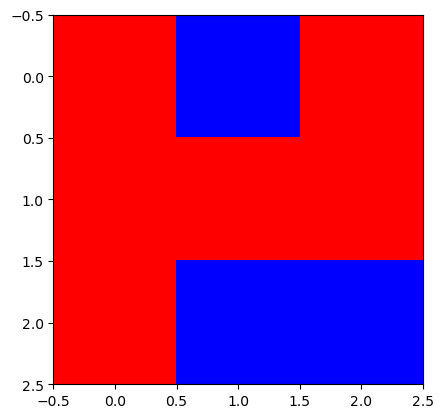

In [177]:
plot(state)

In [178]:
def delta_energy(initial_lattice: np.ndarray, spin_to_flip: tuple[int, int]) -> int:
    #Calculates E_new - E_old
    L = initial_lattice.shape[0]
    sum_of_neighbors = 0
    x,y = spin_to_flip[0], spin_to_flip[1]

    sum_of_neighbors += initial_lattice[(x + 1)%L, y]
    sum_of_neighbors += initial_lattice[(x - 1)%L, y]

    sum_of_neighbors += initial_lattice[x, (y + 1)%L]
    sum_of_neighbors += initial_lattice[x, (y - 1)%L]
     
    return 4 * sum_of_neighbors * initial_lattice[x, y]


In [181]:
print(delta_energy(state, [2,2]))

-8.0


In [165]:
new_state = state.copy()
new_state[4,4] = state[4,4] * -1

IndexError: index 4 is out of bounds for axis 0 with size 3

In [125]:
energy(state)

-64.0

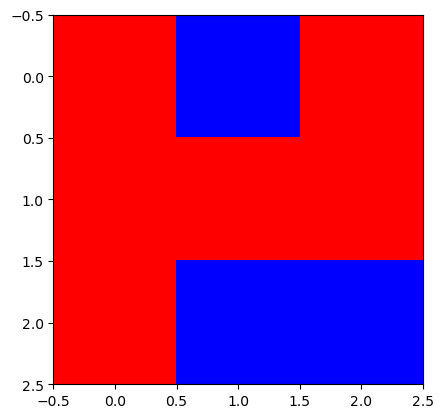

In [182]:
plot(state)

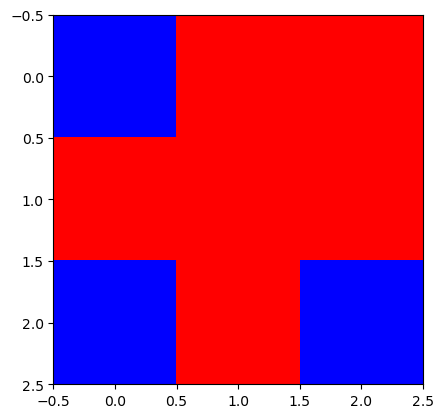

In [183]:
plot(new_state)

In [184]:
energy(new_state) - energy(state)

0.0

In [185]:
def flip_spin_in_lattice(lattice: np.ndarray, spin: tuple[int,int]) -> np.ndarray:
    #given a lattice l, return a new lattice l'
    spin_to_flip_x, spin_to_flip_y = spin
    new_lattice = lattice.copy()
    new_lattice[spin_to_flip_x, spin_to_flip_y] = lattice[spin_to_flip_x, spin_to_flip_y] * -1
    return new_lattice

In [186]:
energy(flip_spin_in_lattice(state, [0,0])) - energy(state)

8.0

In [187]:
delta_energy(state, [0,0])

8.0

In [188]:
def flip_random_spin(lattice: np.ndarray) -> tuple[int, int]:
    L = lattice.shape[0]
    return np.random.randint(0, L, size = (1,2))[0]

In [156]:
def metropolis(proposal_func, init_dist, score_func,
                        num_iters, steps=30):
    """
    Runs the metropolis-hastings algorithm for
    num_iters iterations, using proposal_func
    to generate candidate states and scorer to
    assign probability scores to candidate
    states.
    
    proposal_func: function that proposes
        candidate state; takes in current state as
        argument and returns candidate state
    init_func: function that proposes starting
        state; takes no arguments and returns a
        sample state
    score_func: function that calculates f(y)/f(x)
        * g(y,x)/g(x,y); takes in two state samples
        (the current sample x then the candidate y).
    
    Returns a sequence of every step-th sample. You 
    should only sample on upon acceptance of a new
    proposal. Do not keep sampling the current state.
    
    Note the total number of samples will NOT be
    equal to num_iters. num_iters is the total number
    of proposals we generate.
    """
    samples = []
    sample = init_dist
    for sweep in range(num_iters):
        for step in range(steps):
            candidate = proposal_func(sample)
            acceptance_prob = min(1, score_func(sample, candidate))
            if np.random.uniform() < acceptance_prob:
                sample = move_spins(sample, candidate)
                if sweep > 20:
                    samples.append(sample.flatten())
    return samples[::step]

In [220]:
def metropolis_hasting_sampler(init_dist, beta, num_iters, step_size):
    samples = []
    sample = init_dist
    for i in range(num_iters):
        candidate_spin = flip_random_spin(sample)
        acceptance_prop = min(1, np.exp(-beta * delta_energy(sample, candidate_spin)))
        if (acceptance_prop > np.random.random()):
            sample = flip_spin_in_lattice(sample, candidate_spin)
            samples.append(sample)
    return samples
            

In [267]:
mh_results = metropolis_hasting_sampler(generate_lattice(30), 1, 100_000, 1)
print(len(mh_results))

5494


In [268]:
def turn_into_number(samples):
    res = []
    for sample in samples:
        flattened_sample = sample.flatten().tolist()
        binary_string = ''.join(str(1 if bit == 1 else 0) for bit in flattened_sample)
        res.append(int(binary_string, 2))
    return res


In [271]:
mh_results_numbers = turn_into_number(mh_results)

[7945098849358574626424189114385753230241863895684460505165988191970162634557652686417310802444882826183412601847977615490783905949236640467859014465096801250905803782445768112161980446978758717075731392865598209578368675181295270634589002961141476931728642354907265975715, 7945098849358574626424189114386169981143918886576590495902908270582484181952797430677335568558118078510776203852447705003338378092408073587271104042624669301009186242763290821915251123856639664424451018775502151971238163557840830948097495873765332603480984633737963718051, 7945098849358574626424189114386169981143918886576590495902908270582484181952797430677335568558118078510776203852447705003338378092408073587271104042624669301009186242763290821915251123856639664424451018775495569953008878733672211071367266471745401660018450314284569281955, 794509884935857462642418911438616998114391888657659049590290827058248418195279743067733556855811807851077620385244770500333837809240807358727110404262466930100918624276329082191525

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

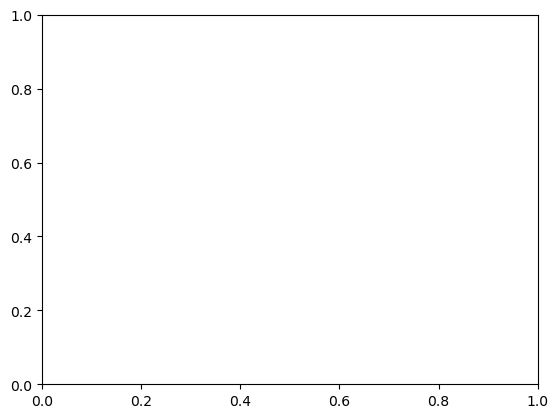

In [270]:
plt.hist(mh_results_numbers)